### Loading data

In [1]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 784)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        #if not os.path.exists(filename):
        #    download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    script_dir=os.getcwd()
    rel_path="Input_data/"
    abs_path=os.path.join(script_dir,rel_path)
    X_train = load_mnist_images(abs_path+'train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels(abs_path+'train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images(abs_path+'t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels(abs_path+'t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

### Training Linear SVM

In [2]:
import numpy as np
import sys
import os
from sklearn import svm
from matplotlib import pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test=load_dataset()
X_train=X_train.reshape((50000,784))
clf=svm.LinearSVC(dual=False)
clf.fit(X_train,y_train)
X_val=X_val.reshape((10000,784))

In [3]:
X_test=X_test.reshape((10000,784))
clf.score(X_test,y_test)

0.9153

### Isolating a single class, finding non-normalized distances from class hyperplane

In [4]:
one_array=np.where(y_train==1)
one_y_train=y_train[one_array]
one_X_train=X_train[one_array[0],:]
one_decision_train=clf.decision_function(one_X_train)

In [5]:
clf.score(one_X_train,one_y_train)

0.97904191616766467

### Creating adversarial examples for test, train and single class data

In [7]:
adv_examples_train=np.zeros((50000,784))

count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
print_flag=1
for i in range(50000):
    x_ini=(X_train[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
    adv_examples_train[i,:]=x_adv
    final_class=clf.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_train[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i]:
        count_pure_adv=count_pure_adv+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/50000.0, count_adv/50000.0, count_pure_adv/50000.0

0.9595 0.99976 0.92602


In [8]:
adv_examples_test=np.zeros((10000,784))

count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
print_flag=1
for i in range(10000):
    x_ini=(X_test[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    x_adv=(x_ini-1.0*(clf.coef_[ini_class[0],:]/(np.linalg.norm(clf.coef_[ini_class[0],:])))).reshape((1,784))
    adv_examples_test[i,:]=x_adv
    final_class=clf.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if y_test[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if y_test[i]!=final_class[0] and ini_class[0]==y_test[i]:
        count_pure_adv=count_pure_adv+1
    if y_test[i]!=final_class[0] and ini_class[0]==y_test[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/10000.0, count_adv/10000.0, count_pure_adv/10000.0

0.9538 0.9997 0.915


In [9]:
adv_examples_train_one=np.zeros((5678,784))

count_pure_adv=0.0
count_adv=0.0
count_wrong=0.0
print_flag=1
for i in range(5678):
    x_ini=(one_X_train[i,:]).reshape((1,784))
    ini_class=clf.predict(x_ini)
    x_adv=(x_ini-0.5*(clf.coef_[ini_class[0],:]/np.linalg.norm(clf.coef_[ini_class[0],:]))).reshape((1,784))
    adv_examples_train_one[i,:]=x_adv
    final_class=clf.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv=count_adv+1
    if one_y_train[i]!=final_class[0]:
        count_wrong=count_wrong+1
    if one_y_train[i]!=final_class[0] and ini_class[0]==one_y_train[i]:
        count_pure_adv=count_pure_adv+1
    if one_y_train[i]!=final_class[0] and ini_class[0]==one_y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        print_flag=print_flag+1
print count_wrong/5678.0, count_adv/5678.0, count_pure_adv/5678.0

0.991722437478 1.0 0.979041916168


### Finding non-normalized distance from hyperplane

In [10]:
one_decision_adv=clf.decision_function(adv_examples_train_one)

### Training SVM in reduced dimensions

In [11]:
from sklearn.decomposition import PCA

rd=50

PCA_in_train=X_train
PCA_in_val=X_val
PCA_in_test=X_test

### Doing PCA over the training data
#Fitting the PCA model on training data
pca=PCA(n_components=rd)
pca.fit(PCA_in_train)
#Transforming the training, validation and test data
X_train_dr=pca.transform(PCA_in_train).reshape((50000,rd))
X_test_dr=pca.transform(PCA_in_test).reshape((10000,rd))
X_val_dr=pca.transform(PCA_in_val).reshape((10000,rd))
X_adv_dr=pca.transform(adv_examples_train).reshape((50000,rd))
X_adv_one_dr=pca.transform(adv_examples_train_one).reshape((5678,rd))

clf_pca=svm.LinearSVC(dual=False)
clf_pca.fit(X_train_dr,y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Classfication success, non-normalized distances to hyperplane in reduced dim.

In [12]:
one_X_train_dr=X_train_dr[one_array[0],:]
one_decision_train_dr=clf_pca.decision_function(one_X_train_dr)
clf_pca.score(X_train_dr,y_train)

0.89336000000000004

In [13]:
clf_pca.score(one_X_train_dr,one_y_train)

0.97005988023952094

In [14]:
clf_pca.score(X_test_dr,y_test)

0.90169999999999995

### Adversarial examples for training data, single class data

In [15]:
count_pure_adv_pca=0.0
count_adv_pca=0.0
count_wrong_pca=0.0
#print_flag_pca=0
for i in range(50000):
    x_ini=(X_train_dr[i,:]).reshape((1,rd))
    ini_class=clf_pca.predict(x_ini)
    x_adv=(x_ini-2.26*(clf_pca.coef_[ini_class[0],:]/(np.linalg.norm(clf_pca.coef_[ini_class[0],:])))).reshape((1,rd))
    #x_adv=X_adv_dr[i,:].reshape((1,rd))
    final_class=clf_pca.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv_pca=count_adv_pca+1
    if y_train[i]!=final_class[0]:
        count_wrong_pca=count_wrong_pca+1
    if y_train[i]!=final_class[0] and ini_class[0]==y_train[i]:
        count_pure_adv_pca=count_pure_adv_pca+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_pca/50000.0, count_adv_pca/50000.0, count_pure_adv_pca/50000.0

0.84056 0.88888 0.78244


In [16]:
one_X_adv_dr=np.zeros((5678,rd))
count_pure_adv_pca=0.0
count_adv_pca=0.0
count_wrong_pca=0.0
#print_flag_pca=0
for i in range(5678):
    x_ini=(one_X_train_dr[i,:]).reshape((1,rd))
    ini_class=clf_pca.predict(x_ini)
    x_adv=(x_ini-1.0*(clf_pca.coef_[1,:]/(np.linalg.norm(clf_pca.coef_[1,:])))).reshape((1,rd))
    one_X_adv_dr[i,:]=x_adv
    #x_adv=X_adv_dr[i,:].reshape((1,rd))
    final_class=clf_pca.predict(x_adv)
    if ini_class[0]!=final_class[0]:
        count_adv_pca=count_adv_pca+1
    if one_y_train[i]!=final_class[0]:
        count_wrong_pca=count_wrong_pca+1
    if one_y_train[i]!=final_class[0] and ini_class[0]==one_y_train[i]:
        count_pure_adv_pca=count_pure_adv_pca+1
    #if y_train[i]!=final_class[0] and ini_class[0]==y_train[i] and print_flag==0:
        #plt.imshow((x_ini.reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #plt.imshow(((x_adv-x_ini).reshape((28,28)))*255, cmap='gray', interpolation='nearest', vmin=0, vmax=255)
        #print_flag=print_flag+1
print count_wrong_pca/5678.0, count_adv_pca/5678.0, count_pure_adv_pca/5678.0

0.246389573794 0.218034519197 0.216449454033


### Non-normalized distance to hyperplane for single class

In [17]:
one_decision_adv_dr=clf_pca.decision_function(one_X_adv_dr)

In [18]:
w_one_norm=np.linalg.norm(clf.coef_[1,:])

In [19]:
w_one_norm_pca=np.linalg.norm(clf_pca.coef_[1,:])

In [20]:
w_one_norm

10.837926065287185

In [21]:
w_one_norm_pca

1.5093393028612399

In [28]:
np.amax(one_decision_train[:,1])/w_one_norm

0.24774809370118669

In [22]:
np.amax(one_decision_train_dr[:,1])/w_one_norm_pca

1.4291282376351411

In [23]:
one_plane_distance=one_decision_train[:,1]/w_one_norm

In [24]:
one_plane_distance_dr=one_decision_train_dr[:,1]/w_one_norm_pca

In [32]:
one_margin_indices=np.where(one_plane_distance>1)[0]

In [33]:
one_margin_indices_dr=np.where(one_plane_distance_dr>1)[0]

In [34]:
one_margin_indices.shape

(0,)

In [35]:
one_margin_indices_dr.shape

(415,)

In [25]:
from matplotlib import pyplot as plt

In [36]:
y_1=np.ones_like(one_plane_distance)
y_2=np.zeros_like(one_plane_distance_dr)

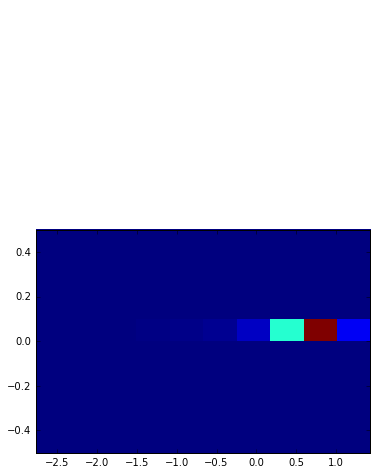

In [38]:
plt.hist2d(one_plane_distance,y_1,(10,10),cmap=plt.cm.jet)
plt.hist2d(one_plane_distance_dr,y_2,(10,10),cmap=plt.cm.jet)
plt.show()